In [1]:
from pathlib import Path
from functools import reduce

import matplotlib.pyplot as plt
from cytoolz import groupby

from lhotse.recipes.librimix import prepare_librimix
from lhotse.features import FeatureSetBuilder, FeatureExtractor
from lhotse.cut import make_cuts_from_features, CutSet
from lhotse.manipulation import combine
from lhotse.dataset.source_separation import PreMixedSourceSeparationDataset, DynamicallyMixedSourceSeparationDataset

# Download MiniLibriMix

In [2]:
%%bash
if [ ! -d MiniLibriMix ]; then
  wget https://zenodo.org/record/3871592/files/MiniLibriMix.zip
  unzip MiniLibriMix.zip
fi

# Prepare audio and supervision manifests

In [3]:
root_dir = Path('.')
librimix_csv = root_dir / 'MiniLibriMix/metadata/mixture_train_mix_both.csv'
sample_duration = 3.0

In [4]:
librimix_manifests = prepare_librimix(librimix_csv, 'librimix_nb', with_precomputed_mixtures=True, min_segment_seconds=sample_duration)

# Extract features

In [5]:
for partition, manifests in librimix_manifests.items():
    feature_set_builder = FeatureSetBuilder(
        feature_extractor=FeatureExtractor(type='fbank'),
        output_dir=f'librimix_nb/feats_{partition}',
        root_dir=root_dir
    )
    feature_set = feature_set_builder.process_and_store_recordings(
        recordings=manifests['audio'],
        num_jobs=8
    )
    librimix_manifests[partition]['feats'] = feature_set
    librimix_manifests[partition]['cuts'] = make_cuts_from_features(feature_set)

# Prepare dynamically-mixed audio cuts

In [6]:
# TODO: refactor the library to re-use this function from the CLI script
def mix_by_recording_id(cut_sets):
    all_cuts = combine(*cut_sets)
    recording_id_to_cut = groupby(lambda cut: cut.recording_id, all_cuts)
    mixed_cuts = (
        reduce(lambda left_cut, right_cut: left_cut.overlay(right_cut), cuts[1:], cuts[0])
        for recording_id, cuts in recording_id_to_cut.items()
    )
    return CutSet(cuts={cut.id: cut for cut in mixed_cuts})

In [7]:
clean_mix_cut_set = mix_by_recording_id(cut_sets=[librimix_manifests['sources']['cuts']])
noisy_mix_cut_set = mix_by_recording_id(cut_sets=[librimix_manifests['sources']['cuts'], librimix_manifests['noise']['cuts']])

# Truncate the cuts to desired duration

In [8]:
def trunc(cut_set):
    return cut_set.truncate(max_duration=sample_duration, offset_type='random', preserve_id=True)

sources_cut_set = trunc(librimix_manifests['sources']['cuts'])
noise_cut_set = trunc(librimix_manifests['noise']['cuts'])
clean_mix_cut_set = trunc(clean_mix_cut_set)
noisy_mix_cut_set = trunc(noisy_mix_cut_set)
premixed_cut_set = trunc(librimix_manifests['premixed']['cuts'])

# Source separation datasets illustration

In [9]:
def show(arr):
    plt.matshow(arr.transpose(0, 1).flip(0))

## Pre-mixed noisy

In [10]:
premix_dataset = PreMixedSourceSeparationDataset(
    sources_set=sources_cut_set,
    mixtures_set=premixed_cut_set,
    root_dir=root_dir
)

# ALTERNATIVELY, when the manifests are already dumped (e.g. using the bash script)
# premix_dataset = PreMixedSourceSeparationDataset(
#     sources_set=CutSet.from_yaml('librimix/cuts_sources.yml'),
#     mixtures_set=CutSet.from_yaml('librimix/cuts_mix.yml'),
#     root_dir=root_dir
# )

In [11]:
sample = premix_dataset[0]

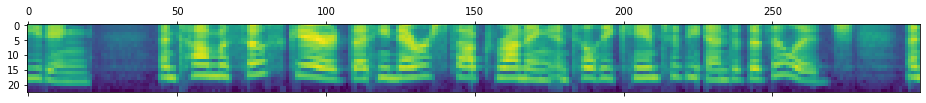

In [12]:
show(sample['sources'][0])

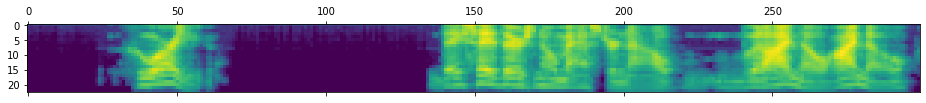

In [13]:
show(sample['sources'][1])

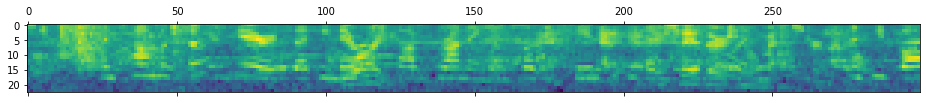

In [14]:
show(sample['mixture'])

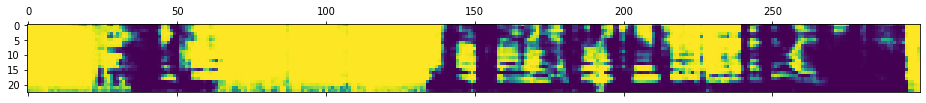

In [15]:
show(sample['real_mask'][0])

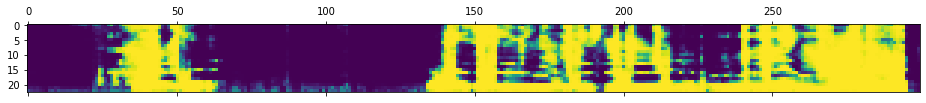

In [16]:
show(sample['real_mask'][1])

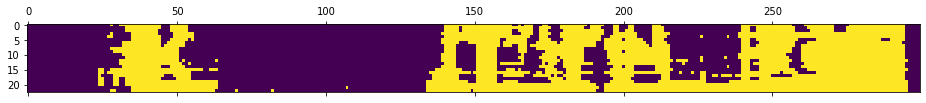

In [17]:
show(sample['binary_mask'])

## Dynamically-mixed noisy

In [18]:
dset_dyn_noise = DynamicallyMixedSourceSeparationDataset(
    sources_set=sources_cut_set,
    mixtures_set=noisy_mix_cut_set,
    nonsources_set=noise_cut_set,
    root_dir=root_dir
)

In [19]:
sample_dyn_noise = dset_dyn_noise[0]

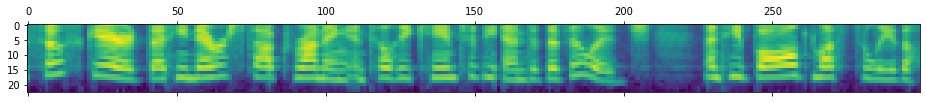

In [20]:
show(sample_dyn_noise['sources'][0])

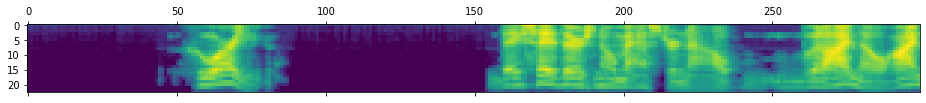

In [21]:
show(sample_dyn_noise['sources'][1])

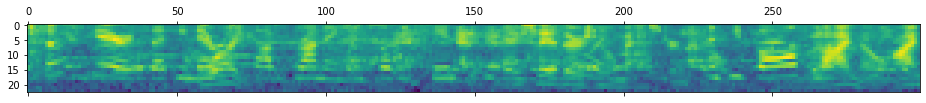

In [22]:
show(sample_dyn_noise['mixture'])

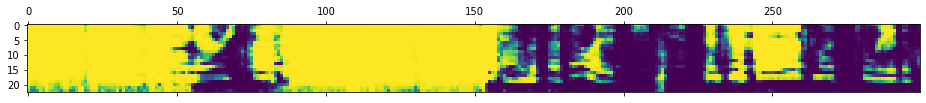

In [23]:
show(sample_dyn_noise['real_mask'][0])

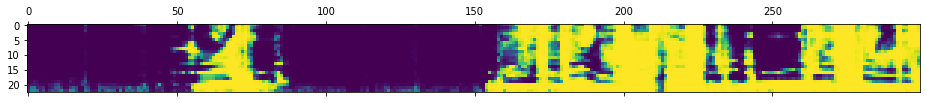

In [24]:
show(sample_dyn_noise['real_mask'][1])

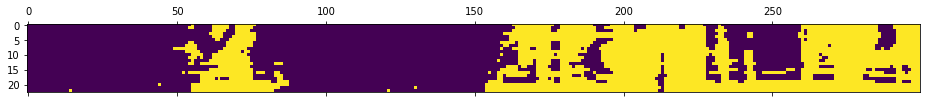

In [25]:
show(sample_dyn_noise['binary_mask'])

## Dynamically-mixed clean

In [27]:
dset_dyn_clean = DynamicallyMixedSourceSeparationDataset(
    sources_set=sources_cut_set,
    mixtures_set=clean_mix_cut_set,
    root_dir=root_dir
)

In [28]:
sample_dyn_clean = dset_dyn_clean[0]

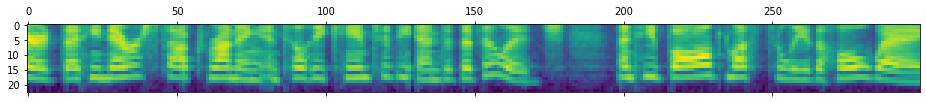

In [29]:
show(sample_dyn_clean['sources'][0])

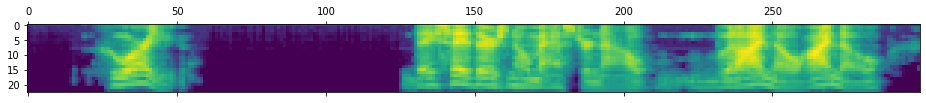

In [30]:
show(sample_dyn_clean['sources'][1])

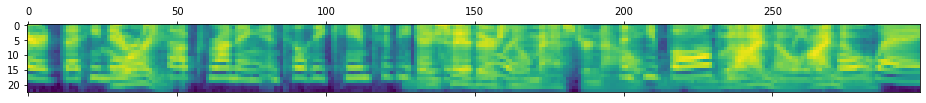

In [31]:
show(sample_dyn_clean['mixture'])

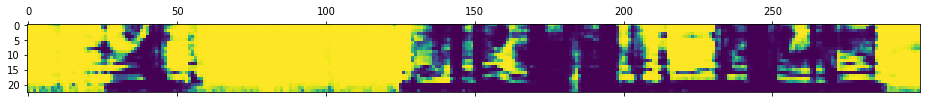

In [32]:
show(sample_dyn_clean['real_mask'][0])

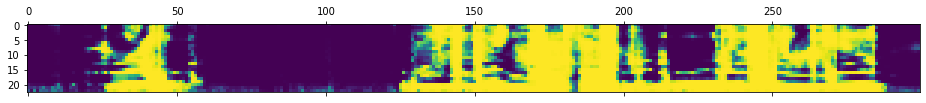

In [33]:
show(sample_dyn_clean['real_mask'][1])

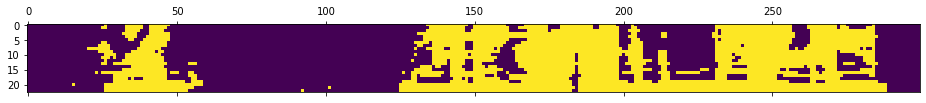

In [34]:
show(sample_dyn_clean['binary_mask'])